In [ ]:
import numpy as np

N = 128
L = 0.160  # in microns
d = L / N
aeff = 0.070  # effective radius in microns

# Define compositions
compositions = 17  # Compositions 1 to 17

# Initialize shape.dat content
shape_data = []

# Write header
shape_data.append(">TARSPH  spherical target")
shape_data.append(f"{N**3} = NAT")

# Lattice vectors
shape_data.append(f"1.000000  0.000000  0.000000 = A_1 vector")
shape_data.append(f"0.000000  1.000000  0.000000 = A_2 vector")
shape_data.append(f"1.000000  1.000000  1.000000 = lattice spacings (d_x,d_y,d_z)/d")
shape_data.append(f"-{N//2}.5 -{N//2}.5 -{N//2}.5 = lattice offset x0(1-3) = (x_TF,y_TF,z_TF)/d for dipole 0 0 0")
shape_data.append("     JA  IX  IY  IZ ICOMP(x,y,z)")

# Generate dipole positions and compositions
for ix in range(N):
    for iy in range(N):
        for iz in range(N):
            x = (ix - (N-1)/2) * d
            y = (iy - (N-1)/2) * d
            z = (iz - (N-1)/2) * d
            r = np.sqrt(x**2 + y**2 + z**2) / 1e3  # convert to microns
            if r <= 0.015:  # Core: 15 nm
                comp = 1
            elif r <= 0.020:  # Shell Layer 1: 15-20 nm
                comp = 2
            # ... continue for layers 2 to 16
            elif r <= 0.090:  # Shell Layer 16: 85-90 nm
                comp = 17
            else:
                comp = 0  # Outside the nanoparticle
            if comp != 0:
                ja = ix + iy*N + iz*N**2 + 1  # JA starts from 1
                shape_data.append(f"{ja:6d} {ix+1:3d} {iy+1:3d} {iz+1:3d} {comp:1d} {comp:1d} {comp:1d}")

# Write to shape.dat
with open('shape.dat', 'w') as f:
    f.write('\n'.join(shape_data))

C:\Users\alexg\AppData\Local\Temp\ipykernel_2976\3596875745.py:88: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use none, you no longer need to clean a Grouper instead.
  ax.voxels(composition_grid > 0, facecolors=plt.cm.viridis(composition_grid / max(1, len(self.layers))),


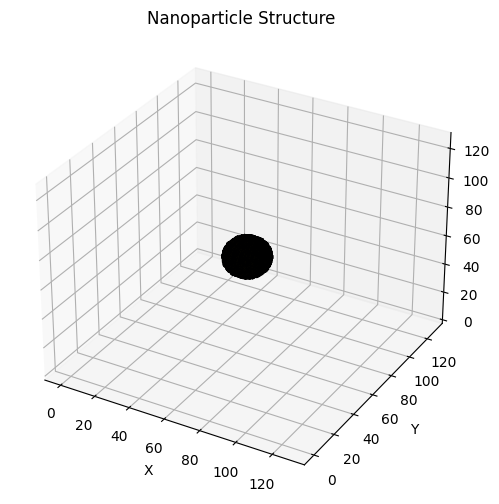

In [1]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


class NanoparticleBuilder:
    def __init__(self, root):
        self.root = root
        self.root.title("Core-Shell Nanoparticle Builder")

        self.layers = []  # Store layers as (radius, comp)

        # UI for adding layers
        self.layer_frame = ttk.Frame(root)
        self.layer_frame.pack(padx=10, pady=10, fill="x")

        ttk.Label(self.layer_frame, text="Shell Radius (nm)").grid(row=0, column=0, padx=5)
        ttk.Label(self.layer_frame, text="Composition").grid(row=0, column=1, padx=5)

        self.radius_var = tk.DoubleVar()
        self.comp_var = tk.IntVar()

        self.radius_entry = ttk.Entry(self.layer_frame, textvariable=self.radius_var, width=10)
        self.radius_entry.grid(row=1, column=0, padx=5)
        self.comp_entry = ttk.Entry(self.layer_frame, textvariable=self.comp_var, width=10)
        self.comp_entry.grid(row=1, column=1, padx=5)

        ttk.Button(self.layer_frame, text="+ Add Layer", command=self.add_layer).grid(row=1, column=2, padx=5)
        ttk.Button(self.layer_frame, text="- Remove Last Layer", command=self.remove_layer).grid(row=1, column=3, padx=5)

        # Display layers
        self.layer_list = tk.Listbox(root, height=8)
        self.layer_list.pack(padx=10, pady=5, fill="x")

        # Plot and Save buttons
        self.button_frame = ttk.Frame(root)
        self.button_frame.pack(pady=10)

        ttk.Button(self.button_frame, text="Plot Structure", command=self.plot_structure).pack(side="left", padx=5)
        ttk.Button(self.button_frame, text="Save Shape", command=self.save_shape).pack(side="right", padx=5)

    def add_layer(self):
        radius = self.radius_var.get()
        comp = self.comp_var.get()
        if radius <= 0 or comp <= 0:
            messagebox.showerror("Input Error", "Radius and Composition must be positive values.")
            return

        if self.layers and radius <= self.layers[-1][0]:
            messagebox.showerror("Input Error", "Radius must be larger than the previous layer.")
            return

        self.layers.append((radius, comp))
        self.layer_list.insert(tk.END, f"Radius: {radius} nm, Composition: {comp}")
        self.radius_var.set(0)
        self.comp_var.set(0)

    def remove_layer(self):
        if self.layers:
            self.layers.pop()
            self.layer_list.delete(tk.END)

    def plot_structure(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to plot.")
            return

        N = 128
        L = 0.160  # in microns
        d = L / N

        x = np.linspace(-L / 2, L / 2, N)
        y = np.linspace(-L / 2, L / 2, N)
        z = np.linspace(-L / 2, L / 2, N)
        X, Y, Z = np.meshgrid(x, y, z)

        r = np.sqrt(X**2 + Y**2 + Z**2) * 1e3  # Convert to nm

        composition_grid = np.zeros_like(r, dtype=int)
        for layer_radius, comp in self.layers:
            composition_grid[(r <= layer_radius) & (composition_grid == 0)] = comp

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(composition_grid > 0, facecolors=plt.cm.viridis(composition_grid / max(1, len(self.layers))),
                  edgecolor='k', alpha=0.8)
        ax.set_title("Nanoparticle Structure")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()

    def save_shape(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to save.")
            return

        shape_data = []
        shape_data.append(">TARSPH  spherical target")
        shape_data.append(f"{128**3} = NAT")
        shape_data.append("1.000000  0.000000  0.000000 = A_1 vector")
        shape_data.append("0.000000  1.000000  0.000000 = A_2 vector")
        shape_data.append("1.000000  1.000000  1.000000 = lattice spacings (d_x,d_y,d_z)/d")
        shape_data.append("-64.5 -64.5 -64.5 = lattice offset x0(1-3) = (x_TF,y_TF,z_TF)/d for dipole 0 0 0")
        shape_data.append("     JA  IX  IY  IZ ICOMP(x,y,z)")

        N = 128
        L = 0.160  # in microns
        d = L / N

        for ix in range(N):
            for iy in range(N):
                for iz in range(N):
                    x = (ix - (N - 1) / 2) * d
                    y = (iy - (N - 1) / 2) * d
                    z = (iz - (N - 1) / 2) * d
                    r = np.sqrt(x**2 + y**2 + z**2) * 1e3  # Convert to nm

                    comp = 0
                    for layer_radius, layer_comp in self.layers:
                        if r <= layer_radius:
                            comp = layer_comp
                            break

                    if comp != 0:
                        ja = ix + iy * N + iz * N**2 + 1
                        shape_data.append(f"{ja:6d} {ix+1:3d} {iy+1:3d} {iz+1:3d} {comp:1d} {comp:1d} {comp:1d}")

        with open("shape.dat", "w") as f:
            f.write("\n".join(shape_data))

        messagebox.showinfo("Success", "Shape saved to shape.dat!")


if __name__ == "__main__":
    root = tk.Tk()
    app = NanoparticleBuilder(root)
    root.mainloop()


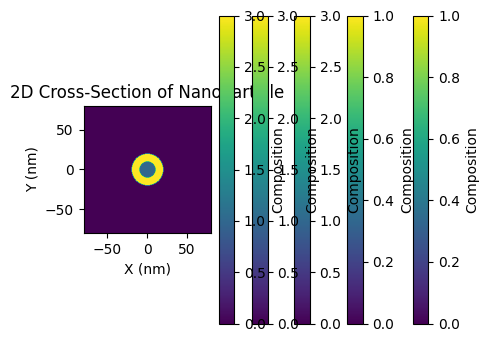

In [ ]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np


class NanoparticleBuilder:
    def __init__(self, root):
        self.root = root
        self.root.title("Core-Shell Nanoparticle Builder")

        self.layers = []  # Store layers as (radius, comp)

        # UI for adding layers
        self.layer_frame = ttk.Frame(root)
        self.layer_frame.pack(padx=10, pady=10, fill="x")

        ttk.Label(self.layer_frame, text="Shell Radius (nm)").grid(row=0, column=0, padx=5)
        ttk.Label(self.layer_frame, text="Composition").grid(row=0, column=1, padx=5)

        self.radius_var = tk.DoubleVar()
        self.comp_var = tk.IntVar()

        self.radius_entry = ttk.Entry(self.layer_frame, textvariable=self.radius_var, width=10)
        self.radius_entry.grid(row=1, column=0, padx=5)
        self.comp_entry = ttk.Entry(self.layer_frame, textvariable=self.comp_var, width=10)
        self.comp_entry.grid(row=1, column=1, padx=5)

        ttk.Button(self.layer_frame, text="+ Add Layer", command=self.add_layer).grid(row=1, column=2, padx=5)
        ttk.Button(self.layer_frame, text="- Remove Last Layer", command=self.remove_layer).grid(row=1, column=3, padx=5)

        # Display layers
        self.layer_list = tk.Listbox(root, height=8)
        self.layer_list.pack(padx=10, pady=5, fill="x")

        # Plot area
        self.figure, self.ax = plt.subplots(figsize=(5, 4))
        self.canvas = FigureCanvasTkAgg(self.figure, master=root)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(padx=10, pady=5)

        # Plot and Save buttons
        self.button_frame = ttk.Frame(root)
        self.button_frame.pack(pady=10)

        ttk.Button(self.button_frame, text="Plot Structure", command=self.plot_structure).pack(side="left", padx=5)
        ttk.Button(self.button_frame, text="Save Shape", command=self.save_shape).pack(side="right", padx=5)

    def add_layer(self):
        radius = self.radius_var.get()
        comp = self.comp_var.get()
        if radius <= 0 or comp <= 0:
            messagebox.showerror("Input Error", "Radius and Composition must be positive values.")
            return

        if self.layers and radius <= self.layers[-1][0]:
            messagebox.showerror("Input Error", "Radius must be larger than the previous layer.")
            return

        self.layers.append((radius, comp))
        self.layer_list.insert(tk.END, f"Radius: {radius} nm, Composition: {comp}")
        self.radius_var.set(0)
        self.comp_var.set(0)

    def remove_layer(self):
        if self.layers:
            self.layers.pop()
            self.layer_list.delete(tk.END)

    def plot_structure(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to plot.")
            return

        self.ax.clear()

        # Generate a 2D slice through the center of the nanoparticle
        N = 256
        L = 0.160  # microns
        d = L / N

        x = np.linspace(-L / 2, L / 2, N)
        y = np.linspace(-L / 2, L / 2, N)
        X, Y = np.meshgrid(x, y)
        r = np.sqrt(X**2 + Y**2) * 1e3  # Convert to nm

        composition_grid = np.zeros_like(r, dtype=int)
        for layer_radius, comp in self.layers:
            composition_grid[(r <= layer_radius) & (composition_grid == 0)] = comp

        cax = self.ax.imshow(
            composition_grid,
            cmap="viridis",
            origin="lower",
            extent=[-L / 2 * 1e3, L / 2 * 1e3, -L / 2 * 1e3, L / 2 * 1e3],
        )
        self.ax.set_title("2D Cross-Section of Nanoparticle")
        self.ax.set_xlabel("X (nm)")
        self.ax.set_ylabel("Y (nm)")

        self.figure.colorbar(cax, ax=self.ax, label="Composition")
        self.canvas.draw()

    def save_shape(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to save.")
            return

        shape_data = []
        shape_data.append(">TARSPH  spherical target")
        shape_data.append(f"{N**3} = NAT")
        shape_data.append("1.000000  0.000000  0.000000 = A_1 vector")
        shape_data.append("0.000000  1.000000  0.000000 = A_2 vector")
        shape_data.append("1.000000  1.000000  1.000000 = lattice spacings (d_x,d_y,d_z)/d")
        shape_data.append(f"-{N//2}.5 -{N//2}.5 -{N//2}.5 = lattice offset x0(1-3) = (x_TF,y_TF,z_TF)/d for dipole 0 0 0")
        shape_data.append("     JA  IX  IY  IZ ICOMP(x,y,z)")

        N = 128
        L = 0.160  # in microns
        d = L / N

        for ix in range(N):
            for iy in range(N):
                for iz in range(N):
                    x = (ix - (N - 1) / 2) * d
                    y = (iy - (N - 1) / 2) * d
                    z = (iz - (N - 1) / 2) * d
                    r = np.sqrt(x**2 + y**2 + z**2) * 1e3  # Convert to nm

                    comp = 0
                    for layer_radius, layer_comp in self.layers:
                        if r <= layer_radius:
                            comp = layer_comp
                            break

                    if comp != 0:
                        ja = ix + iy * N + iz * N**2 + 1
                        shape_data.append(f"{ja:6d} {ix+1:3d} {iy+1:3d} {iz+1:3d} {comp:1d} {comp:1d} {comp:1d}")

        with open("shape.dat", "w") as f:
            f.write("\n".join(shape_data))

        messagebox.showinfo("Success", "Shape saved to shape.dat!")


if __name__ == "__main__":
    root = tk.Tk()
    app = NanoparticleBuilder(root)
    root.mainloop()


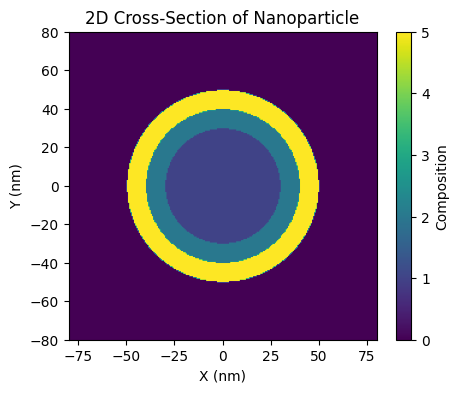

In [ ]:
class NanoparticleBuilder:
    def __init__(self, root):
        self.root = root
        self.root.title("Core-Shell Nanoparticle Builder")

        self.layers = []  # Store layers as (radius, comp)
        self.colorbar = None  # Store colorbar reference

        # UI for adding layers
        self.layer_frame = ttk.Frame(root)
        self.layer_frame.pack(padx=10, pady=10, fill="x")

        ttk.Label(self.layer_frame, text="Shell Radius (nm)").grid(row=0, column=0, padx=5)
        ttk.Label(self.layer_frame, text="Composition").grid(row=0, column=1, padx=5)

        self.radius_var = tk.DoubleVar()
        self.comp_var = tk.IntVar()

        self.radius_entry = ttk.Entry(self.layer_frame, textvariable=self.radius_var, width=10)
        self.radius_entry.grid(row=1, column=0, padx=5)
        self.comp_entry = ttk.Entry(self.layer_frame, textvariable=self.comp_var, width=10)
        self.comp_entry.grid(row=1, column=1, padx=5)

        ttk.Button(self.layer_frame, text="+ Add Layer", command=self.add_layer).grid(row=1, column=2, padx=5)
        ttk.Button(self.layer_frame, text="- Remove Last Layer", command=self.remove_layer).grid(row=1, column=3, padx=5)

        # Display layers
        self.layer_list = tk.Listbox(root, height=8)
        self.layer_list.pack(padx=10, pady=5, fill="x")

        # Plot area
        self.figure, self.ax = plt.subplots(figsize=(5, 4))
        self.canvas = FigureCanvasTkAgg(self.figure, master=root)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(padx=10, pady=5)

        # Plot and Save buttons
        self.button_frame = ttk.Frame(root)
        self.button_frame.pack(pady=10)

        ttk.Button(self.button_frame, text="Plot Structure", command=self.plot_structure).pack(side="left", padx=5)
        ttk.Button(self.button_frame, text="Save Shape", command=self.save_shape).pack(side="right", padx=5)

    def add_layer(self):
        radius = self.radius_var.get()
        comp = self.comp_var.get()
        if radius <= 0 or comp <= 0:
            messagebox.showerror("Input Error", "Radius and Composition must be positive values.")
            return

        if self.layers and radius <= self.layers[-1][0]:
            messagebox.showerror("Input Error", "Radius must be larger than the previous layer.")
            return

        self.layers.append((radius, comp))
        self.layer_list.insert(tk.END, f"Radius: {radius} nm, Composition: {comp}")
        self.radius_var.set(0)
        self.comp_var.set(0)

    def remove_layer(self):
        if self.layers:
            self.layers.pop()
            self.layer_list.delete(tk.END)

    def plot_structure(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to plot.")
            return

        # Clear and recreate the figure and axes to ensure a clean plot
        self.figure.clf()  # Clear the entire figure
        self.ax = self.figure.add_subplot(111)  # Recreate the axes

        # Generate a 2D slice through the center of the nanoparticle
        N = 256
        L = 0.160  # microns
        d = L / N

        x = np.linspace(-L / 2, L / 2, N)
        y = np.linspace(-L / 2, L / 2, N)
        X, Y = np.meshgrid(x, y)
        r = np.sqrt(X**2 + Y**2) * 1e3  # Convert to nm

        # Reset the composition grid and compute new values
        composition_grid = np.zeros_like(r, dtype=int)
        for layer_radius, comp in self.layers:
            composition_grid[(r <= layer_radius) & (composition_grid == 0)] = comp

        # Plot the new composition grid
        cax = self.ax.imshow(
            composition_grid,
            cmap="viridis",
            origin="lower",
            extent=[-L / 2 * 1e3, L / 2 * 1e3, -L / 2 * 1e3, L / 2 * 1e3],
        )
        self.ax.set_title("2D Cross-Section of Nanoparticle")
        self.ax.set_xlabel("X (nm)")
        self.ax.set_ylabel("Y (nm)")

        # Add a new colorbar
        self.figure.colorbar(cax, ax=self.ax, label="Composition")

        # Redraw the canvas
        self.canvas.draw()



    def save_shape(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to save.")
            return

        shape_data = []
        shape_data.append(">TARGSPHER  spherical target")
        shape_data.append(f"{128**3} = NAT")
        shape_data.append("1.000000  0.000000  0.000000 = A_1 vector")
        shape_data.append("0.000000  1.000000  0.000000 = A_2 vector")
        shape_data.append("1.000000  1.000000  1.000000 = lattice spacings (d_x,d_y,d_z)/d")
        shape_data.append(f"-{N//2}.5 -{N//2}.5 -{N//2}.5 = lattice offset x0(1-3) = (x_TF,y_TF,z_TF)/d for dipole 0 0 0")
        shape_data.append("J  JX  JY  JZ ICOMP(x,y,z)")

        N = 128
        L = 0.160  # in microns
        d = L / N

        for ix in range(N):
            for iy in range(N):
                for iz in range(N):
                    x = (ix - (N - 1) / 2) * d
                    y = (iy - (N - 1) / 2) * d
                    z = (iz - (N - 1) / 2) * d
                    r = np.sqrt(x**2 + y**2 + z**2) * 1e3  # Convert to nm

                    comp = 0
                    for layer_radius, layer_comp in self.layers:
                        if r <= layer_radius:
                            comp = layer_comp
                            break

                    if comp != 0:
                        ja = ix + iy * N + iz * N**2 + 1
                        shape_data.append(f"{ja:6d} {ix+1:3d} {iy+1:3d} {iz+1:3d} {comp:1d} {comp:1d} {comp:1d}")

        with open("shape.dat", "w") as f:
            f.write("\n".join(shape_data))

        messagebox.showinfo("Success", "Shape saved to shape.dat!")


if __name__ == "__main__":
    root = tk.Tk()
    app = NanoparticleBuilder(root)
    root.mainloop()


In [ ]:
class NanoparticleBuilder:
    def __init__(self, root):
        self.root = root
        self.root.title("Core-Shell Nanoparticle Builder")

        self.layers = []  # Store layers as (radius, comp)
        self.colorbar = None  # Store colorbar reference

        # UI for adding layers
        self.layer_frame = ttk.Frame(root)
        self.layer_frame.pack(padx=10, pady=10, fill="x")

        ttk.Label(self.layer_frame, text="Shell Radius (nm)").grid(row=0, column=0, padx=5)
        ttk.Label(self.layer_frame, text="Composition").grid(row=0, column=1, padx=5)

        self.radius_var = tk.DoubleVar()
        self.comp_var = tk.IntVar()

        self.radius_entry = ttk.Entry(self.layer_frame, textvariable=self.radius_var, width=10)
        self.radius_entry.grid(row=1, column=0, padx=5)
        self.comp_entry = ttk.Entry(self.layer_frame, textvariable=self.comp_var, width=10)
        self.comp_entry.grid(row=1, column=1, padx=5)

        ttk.Button(self.layer_frame, text="+ Add Layer", command=self.add_layer).grid(row=1, column=2, padx=5)
        ttk.Button(self.layer_frame, text="- Remove Last Layer", command=self.remove_layer).grid(row=1, column=3, padx=5)

        # Display layers
        self.layer_list = tk.Listbox(root, height=8)
        self.layer_list.pack(padx=10, pady=5, fill="x")

        # Plot area
        self.figure, self.ax = plt.subplots(figsize=(5, 4))
        self.canvas = FigureCanvasTkAgg(self.figure, master=root)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(padx=10, pady=5)

        # Plot and Save buttons
        self.button_frame = ttk.Frame(root)
        self.button_frame.pack(pady=10)

        ttk.Button(self.button_frame, text="Plot Structure", command=self.plot_structure).pack(side="left", padx=5)
        ttk.Button(self.button_frame, text="Save Shape", command=self.save_shape).pack(side="right", padx=5)

    def add_layer(self):
        radius = self.radius_var.get()
        comp = self.comp_var.get()
        if radius <= 0 or comp <= 0:
            messagebox.showerror("Input Error", "Radius and Composition must be positive values.")
            return

        if self.layers and radius <= self.layers[-1][0]:
            messagebox.showerror("Input Error", "Radius must be larger than the previous layer.")
            return

        self.layers.append((radius, comp))
        self.layer_list.insert(tk.END, f"Radius: {radius} nm, Composition: {comp}")
        self.radius_var.set(0)
        self.comp_var.set(0)

    def remove_layer(self):
        if self.layers:
            self.layers.pop()
            self.layer_list.delete(tk.END)

    def plot_structure(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to plot.")
            return

        # Clear and recreate the figure and axes to ensure a clean plot
        self.figure.clf()  # Clear the entire figure
        self.ax = self.figure.add_subplot(111)  # Recreate the axes

        # Generate a 2D slice through the center of the nanoparticle
        N = 256
        L = 0.160  # microns
        d = L / N

        x = np.linspace(-L / 2, L / 2, N)
        y = np.linspace(-L / 2, L / 2, N)
        X, Y = np.meshgrid(x, y)
        r = np.sqrt(X**2 + Y**2) * 1e3  # Convert to nm

        # Reset the composition grid and compute new values
        composition_grid = np.zeros_like(r, dtype=int)
        for layer_radius, comp in self.layers:
            composition_grid[(r <= layer_radius) & (composition_grid == 0)] = comp

        # Plot the new composition grid
        cax = self.ax.imshow(
            composition_grid,
            cmap="viridis",
            origin="lower",
            extent=[-L / 2 * 1e3, L / 2 * 1e3, -L / 2 * 1e3, L / 2 * 1e3],
        )
        self.ax.set_title("2D Cross-Section of Nanoparticle")
        self.ax.set_xlabel("X (nm)")
        self.ax.set_ylabel("Y (nm)")

        # Add a new colorbar
        self.figure.colorbar(cax, ax=self.ax, label="Composition")

        # Redraw the canvas
        self.canvas.draw()



    def save_shape(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to save.")
            return

        # Header for the `shape.dat` file
        shape_data = [
            ">TARGSPHER  spherical target",
            f"{N**3} = NAT",  # Total number of dipoles
            "1.000 0.000 0.000 = target vector a1 (in TF)",
            "0.000 1.000 0.000 = target vector a2 (in TF)",
            "1. 1. 1. = d_x/d d_y/d d_z/d (normally 1 1 1)",
            "-64.5 -64.5 -64.5 = X0(1-3) = location in lattice of 'target origin'",
            "J JX JY JZ ICOMPX,ICOMPY,ICOMPZ"
        ]

        N = 128  # Grid size
        L = 0.160  # Microns
        d = L / N

        dipole_id = 1  # Start enumerating dipoles
        for ix in range(N):
            for iy in range(N):
                for iz in range(N):
                    x = (ix - (N - 1) / 2) * d
                    y = (iy - (N - 1) / 2) * d
                    z = (iz - (N - 1) / 2) * d
                    r = np.sqrt(x**2 + y**2 + z**2) * 1e3  # Convert to nm

                    comp = 0
                    for layer_radius, layer_comp in self.layers:
                        if r <= layer_radius:
                            comp = layer_comp
                            break

                    if comp != 0:  # Only write dipoles with a defined composition
                        shape_data.append(
                            f"{dipole_id:6d} {ix:3d} {iy:3d} {iz:3d} {comp:1d} {comp:1d} {comp:1d}"
                        )
                        dipole_id += 1

        # Save to shape.dat
        with open("shape.dat", "w") as f:
            f.write("\n".join(shape_data))

    messagebox.showinfo("Success", "Shape saved to shape.dat!")



if __name__ == "__main__":
    root = tk.Tk()
    app = NanoparticleBuilder(root)
    root.mainloop()
